In [1]:
import Baysor
import Colors
import Images
import MultivariateStats
import Plots
import Random
import Clustering
import CSV

using DataFrames
using DataFramesMeta
using Distributed
using NearestNeighbors
using ProgressMeter
using RCall
using Statistics
using StatsBase

B = Baysor;

PROJECT_PATH = "/home/vpetukhov/spatial/Benchmarking/";

In [2]:
R"""
library(ggplot2)
library(ggbeeswarm)
theme_set(theme_bw())
""";

In [3]:
addprocs(max(2 - nprocs(), 0))
@everywhere begin
    using DataFrames
    using Baysor
    using Logging
    B = Baysor
end;

## osmFISH

In [7]:
@everywhere df_spatial, gene_names = B.load_df("/home/vpetukhov/spatial/Benchmarking/run_results/spacejam2/allen_sm_fish/allen_prior/segmentation.csv");

In [5]:
assignments = @showprogress pmap(1:12) do i
    with_logger(NullLogger()) do
        Random.seed!(i)
        bm_data = B.initial_distribution_arr(df_spatial; n_frames=1, scale=49.0, scale_std=12.25, min_molecules_per_cell=30)[1];
        B.bmm!(bm_data, n_iters=400, new_component_frac=0.3, min_molecules_per_cell=30, assignment_history_depth=100, verbose=false);
        res = bm_data.assignment, B.estimate_assignment_by_history(bm_data)
        bm_data = nothing
        return res
#         return bm_data
    end
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:25:37


In [13]:
raw_assignments = getindex.(assignments, 1);
avg_assignments = getindex.(getindex.(assignments, 2), 1);

@time nmi_raw = vcat([Float64[Clustering.mutualinfo(raw_assignments[i], raw_assignments[j]) for j in 1:(i-1)] for i in 1:length(avg_assignments)]...);
@time nmi_avg = vcat([Float64[Clustering.mutualinfo(avg_assignments[i], avg_assignments[j]) for j in 1:(i-1)] for i in 1:length(avg_assignments)]...);

@time ari_raw = vcat([Float64[Clustering.randindex(raw_assignments[i], raw_assignments[j])[1] for j in 1:(i-1)] for i in 1:length(avg_assignments)]...);
@time ari_avg = vcat([Float64[Clustering.randindex(avg_assignments[i], avg_assignments[j])[1] for j in 1:(i-1)] for i in 1:length(avg_assignments)]...);

 10.686299 seconds (88.58 k allocations: 16.575 GiB, 6.63% gc time)
 10.150382 seconds (88.58 k allocations: 15.291 GiB, 6.35% gc time)
 10.030105 seconds (281.91 k allocations: 16.585 GiB, 6.99% gc time)
  8.945709 seconds (89.71 k allocations: 15.291 GiB, 7.09% gc time)


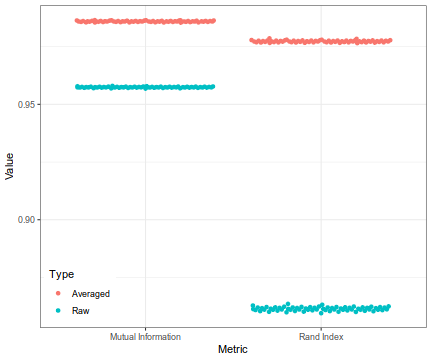

RObject{VecSxp}


In [25]:
R"""
ggplot($p_df_osm, aes(x=Metric, y=Value, color=Type)) + geom_quasirandom() + theme(legend.position=c(0.01, 0.01), legend.justification=c(0, 0))
"""

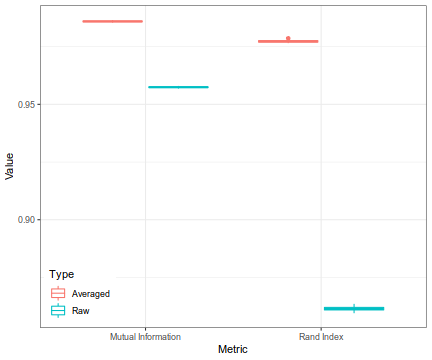

RObject{VecSxp}


In [21]:
p_df_osm = vcat([DataFrame(:Metric => m, :Type => t, :Value => v, :Protocol => "osmFISH") 
        for (m, t, v) in zip(repeat(["Mutual Information", "Rand Index"], inner=2), repeat(["Raw", "Averaged"], outer=2), [nmi_raw, nmi_avg, ari_raw, ari_avg])]...);

CSV.write("../cache/stability_df_osm.csv", p_df_osm)

R"""
ggplot($p_df_osm, aes(x=Metric, y=Value, color=Type)) + geom_boxplot() + theme(legend.position=c(0.01, 0.01), legend.justification=c(0, 0))
"""

## ISS

In [4]:
@everywhere df_spatial, gene_names = B.load_df("/home/vpetukhov/spatial/Benchmarking/run_results/iss_hippo/ca1_no_prior/segmentation.csv");

In [5]:
assignments = @showprogress pmap(1:30) do i
    with_logger(NullLogger()) do
        Random.seed!(i)
        bm_data = B.initial_distribution_arr(df_spatial; n_frames=1, scale=49.0, scale_std=12.25, min_molecules_per_cell=30)[1];
        B.bmm!(bm_data, n_iters=400, new_component_frac=0.3, min_molecules_per_cell=30, assignment_history_depth=100, verbose=false);
        res = bm_data.assignment, B.estimate_assignment_by_history(bm_data)
        bm_data = nothing
        return res
#         return bm_data
    end
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:02:12


In [35]:
raw_assignments = getindex.(assignments, 1);
avg_assignments = getindex.(getindex.(assignments, 2), 1);

@time nmi_raw = vcat([Float64[Clustering.mutualinfo(raw_assignments[i], raw_assignments[j]) for j in 1:(i-1)] for i in 1:length(avg_assignments)]...);
@time nmi_avg = vcat([Float64[Clustering.mutualinfo(avg_assignments[i], avg_assignments[j]) for j in 1:(i-1)] for i in 1:length(avg_assignments)]...);

@time ari_raw = vcat([Float64[Clustering.randindex(raw_assignments[i], raw_assignments[j])[1] for j in 1:(i-1)] for i in 1:length(avg_assignments)]...);
@time ari_avg = vcat([Float64[Clustering.randindex(avg_assignments[i], avg_assignments[j])[1] for j in 1:(i-1)] for i in 1:length(avg_assignments)]...);

  0.416629 seconds (92.56 k allocations: 625.666 MiB, 4.51% gc time)
  0.298680 seconds (92.52 k allocations: 554.792 MiB, 1.61% gc time)
  0.265653 seconds (95.52 k allocations: 625.761 MiB, 4.20% gc time)
  0.220280 seconds (95.50 k allocations: 554.884 MiB, 5.92% gc time)


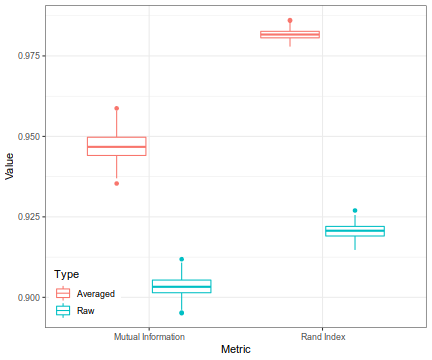

RObject{VecSxp}


In [36]:
p_df_iss = vcat([DataFrame(:Metric => m, :Type => t, :Value => v, :Protocol => "ISS") 
        for (m, t, v) in zip(repeat(["Mutual Information", "Rand Index"], inner=2), repeat(["Raw", "Averaged"], outer=2), [nmi_raw, nmi_avg, ari_raw, ari_avg])]...);

CSV.write("../cache/stability_df_iss.csv", p_df_iss)

R"""
ggplot($p_df_iss, aes(x=Metric, y=Value, color=Type)) + geom_boxplot() + theme(legend.position=c(0.01, 0.01), legend.justification=c(0, 0))
"""

## STARmap

In [3]:
df_spatial, gene_names = B.load_df("/home/vpetukhov/spatial/Benchmarking/run_results/star_map_vis_1020/segmentation.csv");

In [4]:
@time bm_data = B.initial_distribution_arr(df_spatial; n_frames=1, scale=100.0, scale_std="25%", min_molecules_per_cell=30)[1];

┌ Info: Estimate confidence per molecule
└ @ Baysor /home/vpetukhov/.julia/dev/Baysor/src/data_processing/initialization.jl:231
┌ Info: Done
└ @ Baysor /home/vpetukhov/.julia/dev/Baysor/src/data_processing/initialization.jl:234
┌ Info: #frames: 1; mean number of molecules per frame: 1.224917e6.
└ @ Baysor /home/vpetukhov/.julia/dev/Baysor/src/data_processing/initialization.jl:238
┌ Info: Initializing algorithm. Scale: 100.0, scale std: 25.0, initial #clusters: 81660.
└ @ Baysor /home/vpetukhov/.julia/dev/Baysor/src/data_processing/initialization.jl:292


250.715465 seconds (287.09 M allocations: 79.772 GiB, 3.81% gc time)


In [6]:
# @everywhere df_spatial, gene_names = B.load_df("/home/vpetukhov/spatial/Benchmarking/run_results/star_map_vis_1020/segmentation.csv");

In [13]:
@everywhere bm_data = $bm_data;

In [14]:
assignments = @showprogress pmap(1:12) do i
    with_logger(NullLogger()) do
        Random.seed!(i)
        
#         bm_data = B.initial_distribution_arr(df_spatial; n_frames=1, scale=100.0, scale_std="25%", min_molecules_per_cell=30)[1];
        bdr = deepcopy(bm_data)
        B.bmm!(bdr, n_iters=400, new_component_frac=0.3, min_molecules_per_cell=30, assignment_history_depth=100, verbose=false);
        res = bdr.assignment, B.estimate_assignment_by_history(bdr)
        GC.gc()
        return res
#         return bm_data
    end
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:22:05


In [15]:
raw_assignments = getindex.(assignments, 1);
avg_assignments = getindex.(getindex.(assignments, 2), 1);

@time nmi_raw = vcat([Float64[Clustering.mutualinfo(raw_assignments[i], raw_assignments[j]) for j in 1:(i-1)] for i in 1:length(avg_assignments)]...);
@time nmi_avg = vcat([Float64[Clustering.mutualinfo(avg_assignments[i], avg_assignments[j]) for j in 1:(i-1)] for i in 1:length(avg_assignments)]...);

@time ari_raw = vcat([Float64[Clustering.randindex(raw_assignments[i], raw_assignments[j])[1] for j in 1:(i-1)] for i in 1:length(avg_assignments)]...);
@time ari_avg = vcat([Float64[Clustering.randindex(avg_assignments[i], avg_assignments[j])[1] for j in 1:(i-1)] for i in 1:length(avg_assignments)]...);

 52.963856 seconds (382.69 k allocations: 7.869 GiB, 86.04% gc time)
  2.348824 seconds (88.58 k allocations: 4.359 GiB, 8.46% gc time)
  3.480640 seconds (266.93 k allocations: 7.864 GiB, 5.80% gc time)
  1.672850 seconds (89.71 k allocations: 4.359 GiB, 11.92% gc time)


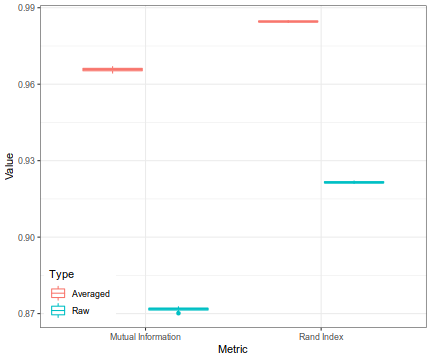

RObject{VecSxp}


In [17]:
p_df_starmap = vcat([DataFrame(:Metric => m, :Type => t, :Value => v, :Protocol => "STARmap") 
        for (m, t, v) in zip(repeat(["Mutual Information", "Rand Index"], inner=2), repeat(["Raw", "Averaged"], outer=2), [nmi_raw, nmi_avg, ari_raw, ari_avg])]...);

CSV.write("../cache/stability_df_starmap.csv", p_df_starmap)

R"""
ggplot($p_df_starmap, aes(x=Metric, y=Value, color=Type)) + geom_boxplot() + theme(legend.position=c(0.01, 0.01), legend.justification=c(0, 0))
"""

## MERFISH

In [2]:
df_spatial, gene_names = B.load_df("/home/vpetukhov/spatial/Benchmarking/run_results/merfish_moffit/segmentation.csv");

In [3]:
@time bm_data = B.initial_distribution_arr(df_spatial; n_frames=1, scale=6.16, scale_std="25%", min_molecules_per_cell=30)[1];

┌ Info: Estimate confidence per molecule
└ @ Baysor /home/vpetukhov/.julia/dev/Baysor/src/data_processing/initialization.jl:180
┌ Info: Done
└ @ Baysor /home/vpetukhov/.julia/dev/Baysor/src/data_processing/initialization.jl:183
┌ Info: #frames: 1; mean number of molecules per frame: 3.73936e6.
└ @ Baysor /home/vpetukhov/.julia/dev/Baysor/src/data_processing/initialization.jl:188
┌ Info: Initializing algorithm. Scale: 6.16, scale std: 1.54, initial #clusters: 249290.
└ @ Baysor /home/vpetukhov/.julia/dev/Baysor/src/data_processing/initialization.jl:195


208.817858 seconds (745.46 M allocations: 104.011 GiB, 12.52% gc time)


In [6]:
@everywhere bm_data = $bm_data;

In [7]:
assignments = @showprogress pmap(1:10) do i
    with_logger(NullLogger()) do
        Random.seed!(i)

#         bm_data = B.initial_distribution_arr(df_spatial; n_frames=1, scale=100.0, scale_std="25%", min_molecules_per_cell=30)[1];
        bdr = deepcopy(bm_data)
        B.bmm!(bdr, n_iters=400, new_component_frac=0.3, min_molecules_per_cell=30, assignment_history_depth=100, verbose=false);
        res = bdr.assignment, B.estimate_assignment_by_history(bdr)
        GC.gc()
        return res
#         return bm_data
    end
end;

Progress: 100%|█████████████████████████████████████████| Time: 6:13:36


In [8]:
raw_assignments = getindex.(assignments, 1);
avg_assignments = getindex.(getindex.(assignments, 2), 1);

@time nmi_raw = vcat([Float64[Clustering.mutualinfo(raw_assignments[i], raw_assignments[j]) for j in 1:(i-1)] for i in 1:length(avg_assignments)]...);
@time nmi_avg = vcat([Float64[Clustering.mutualinfo(avg_assignments[i], avg_assignments[j]) for j in 1:(i-1)] for i in 1:length(avg_assignments)]...);

@time ari_raw = vcat([Float64[Clustering.randindex(raw_assignments[i], raw_assignments[j])[1] for j in 1:(i-1)] for i in 1:length(avg_assignments)]...);
@time ari_avg = vcat([Float64[Clustering.randindex(avg_assignments[i], avg_assignments[j])[1] for j in 1:(i-1)] for i in 1:length(avg_assignments)]...);

 72.085519 seconds (386.88 k allocations: 96.531 GiB, 6.68% gc time)
 49.580850 seconds (88.31 k allocations: 75.110 GiB, 8.26% gc time)
 53.449874 seconds (266.55 k allocations: 96.525 GiB, 6.78% gc time)
 43.867318 seconds (89.33 k allocations: 75.110 GiB, 7.03% gc time)


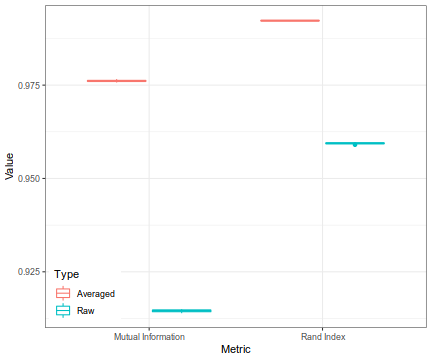

RObject{VecSxp}


In [11]:
p_df_merfish = vcat([DataFrame(:Metric => m, :Type => t, :Value => v, :Protocol => "MERFISH") 
        for (m, t, v) in zip(repeat(["Mutual Information", "Rand Index"], inner=2), repeat(["Raw", "Averaged"], outer=2), [nmi_raw, nmi_avg, ari_raw, ari_avg])]...);

CSV.write("../cache/stability_df_merfish.csv", p_df_merfish)

R"""
ggplot($p_df_merfish, aes(x=Metric, y=Value, color=Type)) + geom_boxplot() + theme(legend.position=c(0.01, 0.01), legend.justification=c(0, 0))
"""

## Aggregate

In [3]:
@time met_df = vcat(CSV.read.(["../cache/stability_df_merfish.csv", "../cache/stability_df_iss.csv", 
            "../cache/stability_df_osm.csv", "../cache/stability_df_starmap.csv"])...);

  9.800966 seconds (22.36 M allocations: 1.073 GiB, 4.38% gc time)


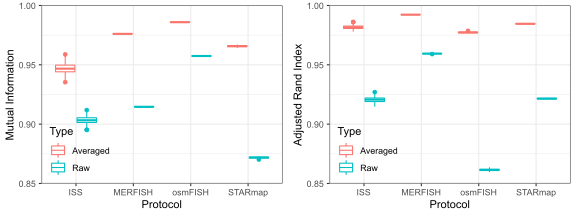

RObject{VecSxp}


In [6]:
p_df = @where(met_df, :Metric .== "Mutual Information");

gg1 = R"""
ggplot($p_df, aes(x=Protocol, y=Value, color=Type)) + geom_boxplot() + 
    scale_y_continuous(name='Mutual Information', limits=c(0.85, 1.0), expand=c(0, 0)) +
    theme(legend.position=c(0.01, 0.01), legend.justification=c(0, 0), legend.background=element_blank())
""";

p_df = @where(met_df, :Metric .!= "Mutual Information");
gg2 = R"""
ggplot($p_df, aes(x=Protocol, y=Value, color=Type)) + geom_boxplot() + 
    scale_y_continuous(name='Adjusted Rand Index', limits=c(0.85, 1.0), expand=c(0, 0)) +
    theme(legend.position=c(0.01, 0.01), legend.justification=c(0, 0), legend.background=element_blank())
""";

RCall.ijulia_setdevice(MIME("image/svg+xml"), width=8, height=3)
gg = R"cowplot::plot_grid"(gg1, gg2);
R"ggsave"("./plots/stability.pdf", gg, width=8, height=3);
gg